In [1]:
#!/usr/bin/env python
# coding: utf-8
get_ipython().run_line_magic('matplotlib', 'inline')
import pandas as pd
import time
import numpy as np
from datetime import datetime
from sklearn.externals import joblib 
import os
from konlpy.tag import Mecab
import lightgbm as lgb
print(lgb.__version__)

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib 
from sklearn.model_selection import StratifiedKFold

import gc

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings(action='ignore')


import torch
print(torch.__version__)
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

from tools import eval_summary

print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
device

/home/aiden/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


2.3.2
1.3.1
GeForce RTX 2070 SUPER
True


device(type='cuda', index=0)

In [2]:
print(os.getcwd())

base_path = '.'

df_train = pd.read_csv(os.path.join(base_path , 'input/train.csv'), index_col=0)
df_test = pd.read_csv(os.path.join(base_path , 'input/public_test.csv'), index_col=0)
df_test['smishing'] = -1

df_fea = pd.concat([df_train, df_test])
df_fea.shape

/home/aiden/src/dacon_14


(297571, 3)

In [3]:
train_size = len(df_train)
print(train_size)

# cat_cols = []
# fea_cols = tfidf_cols + cat_cols + cnt_cols
# fea_cols = cnt_cols + cat_cols
# fea_cols = tfidf_cols + cat_cols
# len(fea_cols)

295945


#### Load Data

In [4]:
# merged_ts = '20191231T113708_5499'
# merged_ts = '20191231T162533_2022'
# merged_ts = '20191231T165424_6099'
# merged_ts = '20191231T111228_8180'
# merged_ts = '20200101T184353_5853'
# merged_ts = '20200102T005929_6546_128_49980' # 984
# merged_ts = '20200102T015155_8438_128_49980' # 986
# merged_ts = '20200102T160226_8438_275_997'
# merged_ts = '20200104T033010_10938_512_49980'

# merged_ts = '20200104T141453_13225_64_49980' #1445
# merged_ts = '20200104T143414_12439_64_49980'


merged_ts = '20200104T151347_9528_64_49980'


train_path = 'data/df_merged_{}_train.pkl'.format(merged_ts)
test_path = 'data/df_merged_{}_test.pkl'.format(merged_ts)
dict_path = 'data/df_merged_{}_fea_dict.pkl'.format(merged_ts)

df_model = joblib.load(train_path)  
df_test = joblib.load(test_path) 
fea_dict = joblib.load(dict_path)

print('model_set\n', df_model['smishing'].value_counts())

model_set
 0    277242
1     18703
Name: smishing, dtype: int64


In [5]:
seq_cols = ['seq_' + str(i) for i in range(64)]
idx_col = [c for c in df_model.columns if '_idx' in c][0]
ridx_col = [c for c in df_model.columns if '_ridx' in c][0]

In [6]:
# df_model[seq_cols] = pd.DataFrame(df_model[idx_col].values.tolist(), df_model.index, dtype=np.int16)
# df_test[seq_cols] = pd.DataFrame(df_model[idx_col].values.tolist(), df_model.index, dtype=np.int16)

In [7]:
df_model.drop(idx_col, axis=1, inplace=True)
df_test.drop(idx_col, axis=1, inplace=True)

df_model.drop(ridx_col, axis=1, inplace=True)
df_test.drop(ridx_col, axis=1, inplace=True)

In [ ]:
no_fea_cols = [
    'tfidf_word_22_0167_xxx 은행',
    'fea__noun_cnt',
]

In [8]:
fea_cols = [c for c in df_model.columns if c not in ['smishing', 'id', idx_col, ridx_col] + no_fea_cols]
# cat_cols = [c for c in fea_cols if 'seq_' in c]
cat_cols = []

len(fea_cols), len(cat_cols)

(9526, 0)

In [9]:
gc.collect()

100

In [10]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295945 entries, 0 to 336378
Columns: 9527 entries, smishing to tfidf_pos_word_22_0999
dtypes: float16(9482), int16(44), int64(1)
memory usage: 5.3 GB


In [11]:
df_model = df_model.reset_index()
df_model

,id,smishing,fea__EC,fea__EF,fea__EP,fea__ETM,fea__ETN,fea__IC,fea__JC,fea__JKB,...,tfidf_pos_word_22_0990,tfidf_pos_word_22_0991,tfidf_pos_word_22_0992,tfidf_pos_word_22_0993,tfidf_pos_word_22_0994,tfidf_pos_word_22_0995,tfidf_pos_word_22_0996,tfidf_pos_word_22_0997,tfidf_pos_word_22_0998,tfidf_pos_word_22_0999
0,0,0,0,2,1,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,1,1,2,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,2,5,4,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,1,5,5,7,2,0,1,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,2,1,1,1,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295940,336373,0,5,4,8,7,2,0,2,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295941,336375,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295942,336376,0,5,2,3,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295943,336377,0,3,2,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Params

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

model_ts = datetime.now().strftime('%Y%m%dT%H%M%S')

initscore_filename = ''
params = {
    'boosting':'gbdt',
#     'boosting':'dart',
    'num_leaves': 7, 
#     'max_depth': 5,
    'objective': 'binary',
    'metric':'auc',
    'num_threads': 16,
    'learning_rate': 0.005,
#     'is_unbalance': True,
    'scale_pos_weight':200,
    'bagging_fraction':0.5,
    'bagging_freq':10,
    'feature_fraction':0.5,
    'initscore_filename':initscore_filename,
#     'lambda_l1':200,
#     'lambda_l2':2000,
    'device_type':'gpu',
}

data_params = {
    'max_bin':128,
#     'enable_bundle': False,
}
num_round = 15000



#### Train

In [13]:
print('merged_ts', merged_ts, 'model_ts', model_ts)
print(params)
print(data_params)
pred_csv = []
fea_size = -1
try_cnt = 1


for t in tqdm_notebook(range(try_cnt), total=try_cnt, desc = 'Try'):
    fea_cols = [c for c in df_model.columns if c not in ['smishing', 'id', 'score']]
    
    if fea_size > 0:
        fea_cols = list(set(np.random.choice(fea_cols, fea_size)))
        print(t, len(fea_cols), fea_cols[:100])
    else:
        print(t, len(fea_cols))

    [df_model.drop(c, axis=1, inplace=True) for c in df_model.columns if 'smishing_' in c]
    [df_test.drop(c, axis=1, inplace=True) for c in df_test.columns if 'smishing_' in c]

#     X = df_model[fea_cols].values
#     y = df_model['smishing'].values

    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, random_state=8405)
    cnt = 0
    
#     train_data = lgb.Dataset(X, label=y, feature_name=fea_cols, categorical_feature=cat_cols, 
#                              free_raw_data=False, params=data_params)

    # for train_index, valid_index in skf.split(X, y):
    for train_index, valid_index in tqdm_notebook(skf.split(df_model['id'].values, df_model['smishing'].values), total=n_splits, desc = 'CV'):
        print('\n', t, '*' * 20, cnt, '*' * 20)
        
        train_set = lgb.Dataset(df_model.loc[train_index, fea_cols].values, 
                                 label=df_model.loc[train_index, 'smishing'].values, 
                                 feature_name=fea_cols, categorical_feature=cat_cols, 
                                 free_raw_data=True, params=data_params)
        
        valid_set = lgb.Dataset(df_model.loc[valid_index, fea_cols].values, 
                                 label=df_model.loc[valid_index, 'smishing'].values, 
                                 feature_name=fea_cols, categorical_feature=cat_cols, 
                                 free_raw_data=True, params=data_params)

#         train_set = train_data.subset(train_index, params=data_params).construct()
#         valid_set = train_data.subset(valid_index, params=data_params).construct()
        print('train_set', np.unique(train_set.get_label(), return_counts=True))
        print('valid_set', np.unique(valid_set.get_label(), return_counts=True))

        bst = lgb.train(params, train_set, num_round, categorical_feature=cat_cols,
                        early_stopping_rounds=500, 
                        valid_sets=[train_set, valid_set],
                        verbose_eval=200,
                        # init_model=init_model,
                       )
        
        pred_tag = 'smishing_{}_{}__{}'.format(t, cnt, bst.best_iteration)
        print('pred_tag', pred_tag, 'Best Iteration:', bst.best_iteration)

        renamed_cols = [fea_dict[c] if c in fea_dict.keys() else c for c in fea_cols]

        impt_dict = {k:v for k, v in zip(renamed_cols, bst.feature_importance(importance_type='split'))}
        print('<split>\n', sorted(impt_dict.items(), key=(lambda x:x[1]), reverse=True)[:5])
        joblib.dump(impt_dict, 'model/{}_{}_split.pkl'.format(model_ts, pred_tag))

        impt_dict = {k:v for k, v in zip(renamed_cols, bst.feature_importance(importance_type='gain'))}    
        print('<gain>\n', sorted(impt_dict.items(), key=(lambda x:x[1]), reverse=True)[:5])
        joblib.dump(impt_dict, 'model/{}_{}_gain.pkl'.format(model_ts, pred_tag))
        
        
        df_pred_valid = pd.DataFrame(index=valid_index, 
                               data=bst.predict(df_model.loc[valid_index, fea_cols].values),
                               columns=['score'])
        
        df_pred_valid['type'] = 'valid'
        df_pred_valid['smishing'] = df_model.loc[valid_index, 'smishing'].values
        
        df_pred_train = pd.DataFrame(index=train_index, 
                               data=bst.predict(df_model.loc[train_index, fea_cols].values),
                               columns=['score'])
        
        df_pred_train['type'] = 'train'
        df_pred_train['smishing'] = df_model.loc[train_index, 'smishing'].values
        
        
        print('valid\n', eval_summary(df_pred_valid['smishing'].values, 
                                      df_pred_valid['score'].values, cut_off=0.5))

        print('train\n', eval_summary(df_pred_train['smishing'].values, 
                                      df_pred_train['score'].values, cut_off=0.5))
        
        df_pred_model = pd.concat([df_pred_train, df_pred_valid])
              
        df_pred_model[['score', 'smishing']].to_csv('submit/{}_{}_lgb_score.csv'.format(model_ts, pred_tag), index=True)
        print('model\n', eval_summary(df_pred_model['smishing'].values, df_pred_model['score'].values, cut_off=0.5))
        
        df_test['smishing'] = bst.predict(df_test[fea_cols].values)    
        df_test[['smishing']].to_csv('submit/{}_{}_lgb.csv'.format(model_ts, pred_tag), index=True)
        pred_csv.append('submit/{}_{}_lgb.csv'.format(model_ts, pred_tag))
        
        del train_set, valid_set
        gc.collect()
        cnt = cnt + 1


merged_ts 20200104T151347_9528_64_49980 model_ts 20200105T050745
{'boosting': 'gbdt', 'num_leaves': 7, 'objective': 'binary', 'metric': 'auc', 'num_threads': 16, 'learning_rate': 0.005, 'scale_pos_weight': 200, 'bagging_fraction': 0.5, 'bagging_freq': 10, 'feature_fraction': 0.4, 'initscore_filename': ''}
{'max_bin': 128}


0 9526



 0 ******************** 0 ********************
train_set (array([0, 1]), array([221793,  14962]))
valid_set (array([0, 1]), array([55449,  3741]))
Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.999942	valid_1's auc: 0.999724
[400]	training's auc: 0.999995	valid_1's auc: 0.999823
[600]	training's auc: 0.999998	valid_1's auc: 0.999892
[800]	training's auc: 0.999999	valid_1's auc: 0.99994
[1000]	training's auc: 0.999999	valid_1's auc: 0.999962
[1200]	training's auc: 1	valid_1's auc: 0.999974
[1400]	training's auc: 1	valid_1's auc: 0.999985
[1600]	training's auc: 1	valid_1's auc: 0.999989
[1800]	training's auc: 1	valid_1's auc: 0.999992
[2000]	training's auc: 1	valid_1's auc: 0.999993
[2200]	training's auc: 1	valid_1's auc: 0.999994
[2400]	training's auc: 1	valid_1's auc: 0.999996
[2600]	training's auc: 1	valid_1's auc: 0.999997
[2800]	training's auc: 1	valid_1's auc: 0.999997
[3000]	training's auc: 1	valid_1's auc: 0.999997
[3200]	training's auc: 1	

[1400]	training's auc: 1	valid_1's auc: 0.999999
[1600]	training's auc: 1	valid_1's auc: 1
[1800]	training's auc: 1	valid_1's auc: 1
[2000]	training's auc: 1	valid_1's auc: 1
[2200]	training's auc: 1	valid_1's auc: 1
[2400]	training's auc: 1	valid_1's auc: 1
[2600]	training's auc: 1	valid_1's auc: 1
[2800]	training's auc: 1	valid_1's auc: 1
[3000]	training's auc: 1	valid_1's auc: 1
Early stopping, best iteration is:
[2547]	training's auc: 1	valid_1's auc: 1
pred_tag smishing_0_3__2547 Best Iteration: 2547
<split>
 [('tfidf_pos_word_22_0072_xxx 은행', 569), ('tfidf_pos_char_11_0000_ ', 349), ('tfidf_word_11_0761_올림', 307), ('tfidf_word_22_0164_xxx 올림', 213), ('tfidf_word_22_0167_xxx 은행', 184)]
<gain>
 [('cnt_0715_자', 9646236.840148926), ('fea__NNG', 6309678.482791901), ('fea__noun_cnt', 4403920.885671616), ('fea__text_len', 1301859.7569961548), ('tfidf_word_11_0761_올림', 946270.7339038849)]
valid
 {'auc': 0.9999999807113202, 'confusion_matrix': array([[55438,    10],
       [    0,  3740]]

In [14]:
print(len(pred_csv))

df_submit = pd.concat([pd.read_csv(csv, index_col=0) for csv in pred_csv], axis=1)

5


In [27]:
pred_csv

['submit/20200105T050745_smishing_0_0__7778_lgb.csv',
 'submit/20200105T050745_smishing_0_1__4309_lgb.csv',
 'submit/20200105T050745_smishing_0_2__3856_lgb.csv',
 'submit/20200105T050745_smishing_0_3__2547_lgb.csv',
 'submit/20200105T050745_smishing_0_4__4675_lgb.csv']

In [29]:
df_submit = df_test[['smishing']]
df_submit['smishing'] = 0
for csv in [c for c in pred_csv if 'smishing_0_4' not in c]:
    print(csv)
    df = pd.read_csv(csv, index_col=0)
    df_submit['smishing'] = df_submit['smishing'] + df['smishing']
    c = csv.split('__')[0][-1]
    df_submit['smishing_{}'.format(c)] = df['smishing']
#     display(df.head())
df_submit['smishing'] = df_submit['smishing'] / len(pred_csv)

submit/20200105T050745_smishing_0_0__7778_lgb.csv
submit/20200105T050745_smishing_0_1__4309_lgb.csv
submit/20200105T050745_smishing_0_2__3856_lgb.csv
submit/20200105T050745_smishing_0_3__2547_lgb.csv


In [30]:
pred_cols = [c for c in df_submit.columns if 'smishing_' in c]
# pred_cols.remove('smishing_1')
# pred_cols.remove('smishing_2')
df_submit['std'] = df_submit[pred_cols].std(axis=1)
df_submit['median'] = df_submit[pred_cols].median(axis=1)

In [31]:
df_std = df_submit[df_submit['std'] < 1]
print(df_std.shape)
df_std.sort_values('std', ascending=False).head(30)

(1626, 7)


,smishing,smishing_0,smishing_1,smishing_2,smishing_3,std,median
id,,,,,,,
340274,0.553468,0.040890,0.934895,0.858354,0.933200,0.435428,0.895777
340597,0.386624,0.001272,0.239634,0.797530,0.894686,0.431935,0.518582
341178,0.542576,0.047653,0.791121,0.916411,0.957693,0.426303,0.853766
341349,0.376202,0.003271,0.578452,0.338716,0.960568,0.403109,0.458584
340483,0.542377,0.079213,0.889974,0.827621,0.915076,0.400862,0.858798
341365,0.396334,0.004835,0.598378,0.427248,0.951208,0.393134,0.512813
340046,0.372582,0.001439,0.457241,0.447381,0.956847,0.390372,0.452311
341111,0.426808,0.005642,0.509381,0.724052,0.894963,0.385651,0.616716
340259,0.426570,0.023565,0.465781,0.736767,0.906735,0.385245,0.601274


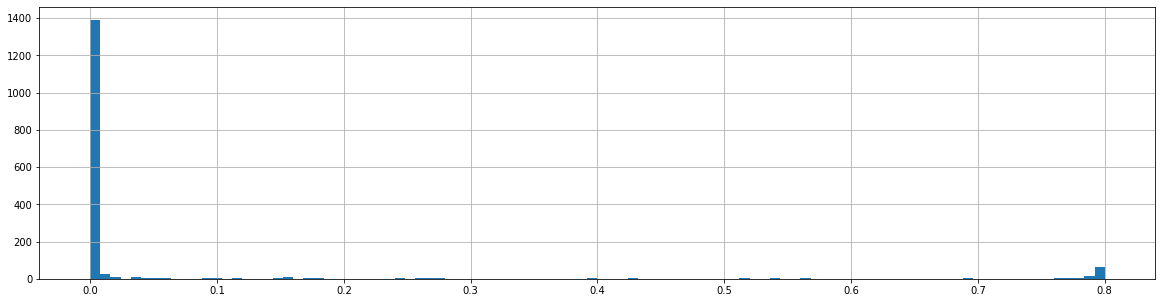

In [32]:
df_submit['smishing'].hist(bins=100, figsize=(20, 5))

In [33]:
(df_submit['smishing'] * 10).astype(int).value_counts(sort=False)

0    1458
1      29
2      16
3       6
4       8
5      10
6       6
7      93
Name: smishing, dtype: int64

In [34]:
print(model_ts)
df_submit[['smishing']].to_csv('submit/{}_lgb_no4.csv'.format(model_ts), index=True)

20200105T050745


In [21]:
# print(len(pred_cols))
# df_test['pred_max'] = df_test[pred_cols].max(axis=1)
# df_test['pred_min'] = df_test[pred_cols].min(axis=1)
# df_test['pred_mean'] = df_test[pred_cols].mean(axis=1)
# df_test['pred_std'] = df_test[pred_cols].std(axis=1)

# print(df_test['pred_std'].max(), df_test['pred_std'].min(), df_test['pred_std'].mean())

# df_test['smishing'] = df_test['pred_mean']

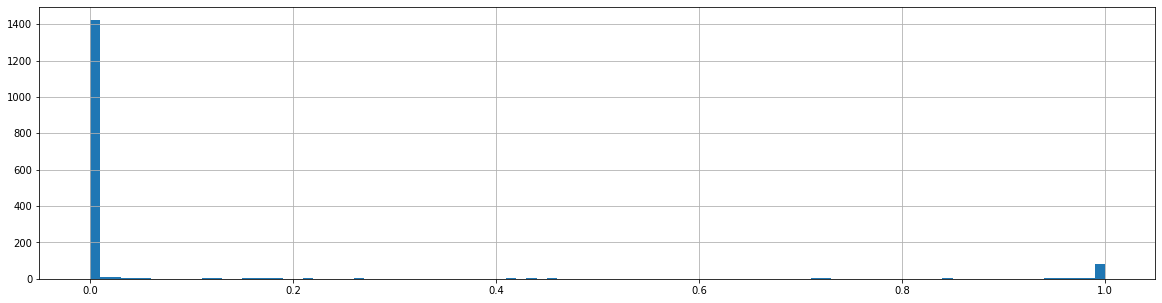

In [22]:
df_test['smishing'].hist(bins=100, figsize=(20, 5))

In [23]:
(df_test['smishing'] * 10).astype(int).value_counts(sort=False)

0    1456
1      26
2      12
3       1
4      10
5       2
6       2
7       7
8       4
9     106
Name: smishing, dtype: int64

In [24]:
model_ts

'20200105T050745'

In [25]:
df_test['smishing'] = df_test['smishing']
df_test[['smishing']].to_csv('submit/{}_lgb_no4.csv'.format(model_ts), index=True)


In [26]:
# df_test['smishing'] = df_test['pred_mean']
# df_test[['smishing']].to_csv('submit/{}_lgb.csv'.format(model_ts), index=True)
# # df_test[['id', 'smishing', 'text']].sort_values('smishing', ascending=False).to_csv('{}_text.csv'.format(model_ts), index=False)
